In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
data = pd.read_csv('customer.csv')
data.drop("Unnamed: 0", axis=1, inplace=True)
data.drop("custid", axis=1, inplace=True)

In [30]:
patients = data.shape[0]
features = data.shape[1] - 1 

not_insured = len(data[data.health_ins == False])
insured = len(data[data.health_ins == True])
val = [not_insured, insured]

percentage_not_insured = (float(not_insured)/patients) * 100
percentage_insured = (float(insured)/patients) * 100

print(f'Total of patients:{patients}')
print(f'Total of columns:{features}')
print(f'Total of patients not insured:{percentage_not_insured} ({percentage_not_insured:.2f}%)')
print(f'Total of patients insured:{percentage_insured} ({percentage_insured:.2f}%)')

Total of patients:72458
Total of columns:12
Total of patients not insured:9.529658560821442 (9.53%)
Total of patients insured:90.47034143917855 (90.47%)


In [31]:
data['is_employed'] = data['is_employed'].fillna(False)

/tmp/ipykernel_50431/3149043678.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_employed'] = data['is_employed'].fillna(False)


In [35]:
data.dropna(inplace=True)

In [36]:
data['age'] = data['age'].replace(0, np.nan)

In [37]:
len(data)

70771

In [38]:
data_encoded = pd.get_dummies(data, drop_first=True)

In [9]:
from scipy.stats import zscore

numerical_cols = data.select_dtypes(include=[np.number])
z_scores = numerical_cols.apply(zscore, nan_policy='omit')
z_scores_df = pd.DataFrame(z_scores, columns=numerical_cols.columns)

In [10]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

imputed_data = imputer.fit_transform(z_scores_df)

# Step 5: Replace the original 'age' column with the imputed values
z_scores_df['age'] = imputed_data[:, 4]

In [11]:
data['income'] = z_scores_df["income"]
data['num_vehicles'] = z_scores_df["num_vehicles"]
data['age'] = z_scores_df["age"]
data['code_column'] = z_scores_df["code_column"]
data['gas_usage'] = z_scores_df["gas_usage"]
data['rooms'] = z_scores_df["rooms"]

In [14]:
data_encoded = pd.get_dummies(data, drop_first=True)

In [15]:
patients = data_encoded.shape[0]
features = data_encoded.shape[1] - 1 

not_insured = len(data_encoded[data_encoded.health_ins == False])
insured = len(data[data_encoded.health_ins == True])
val = [not_insured, insured]

percentage_not_insured = (float(not_insured)/patients) * 100
percentage_insured = (float(insured)/patients) * 100

print(f'Total of patients:{patients}')
print(f'Total of columns:{features}')
print(f'Total of patients not insured:{percentage_not_insured}({percentage_not_insured:.2f}%)')
print(f'Total of patients insured:{percentage_insured}({percentage_insured:.2f}%)')

Total of patients:70771
Total of columns:65
Total of patients not insured:9.089881448615959(9.09%)
Total of patients insured:90.91011855138404(90.91%)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [17]:
X = data_encoded.drop(columns=['health_ins'])
y = data_encoded['health_ins']

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def evaluate_model(model, X_test, y_test):
    # Predict the labels
    y_pred = model.predict(X_test)
    
    # Dictionary to store metrics
    metrics = {}
    
    # Accuracy
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    
    # Precision
    metrics['precision'] = precision_score(y_test, y_pred)  # or 'macro' for multiclass
    
    # Recall
    metrics['recall'] = recall_score(y_test, y_pred)  # or 'macro'
    
    # F1 Score
    metrics['f1_score'] = f1_score(y_test, y_pred)  # or 'macro'
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    [[tn, fp], [fn, tp]] = conf_matrix
    metrics['specifity'] = tn / (tn+fp)
    
    
    metrics['confusion_matrix'] = conf_matrix
    # ROC AUC Score (for binary or multiclass)
    #if hasattr(model, "predict_proba"):
    #    y_prob = model.predict_proba(X_test)
    #    # Check if it's binary classification, then select only the positive class probabilities
    #    if y_prob.shape[1] == 2:
    #        y_prob = y_prob[:, 1]  # Use only the probability for the positive class
    #    metrics['roc_auc'] = roc_auc_score(y_test, y_prob, multi_class="ovr" if len(np.unique(y_test)) > 2 else None)
    #elif hasattr(model, "decision_function"):
    #    y_score = model.decision_function(X_test)
    #    metrics['roc_auc'] = roc_auc_score(y_test, y_score, multi_class="ovr" if len(np.unique(y_test)) > 2 else None)
    
    
    return metrics

# Training without smote

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100)  # You can adjust n_estimators
rfc_model.fit(X_train, y_train)

rfc_y_pred = rfc_model.predict(X_test)

rfc_metrics = evaluate_model(rfc_model, X_test, y_test)

for metric, value in rfc_metrics.items():
    print(f"{metric}: {value}")

accuracy: 0.9027905333804309
precision: 0.9124460431654676
recall: 0.9876187509733686
f1_score: 0.9485453593598085
specifity: 0.07311500380807312
confusion_matrix: [[   96  1217]
 [  159 12683]]


<Axes: xlabel='prevision', ylabel='real'>

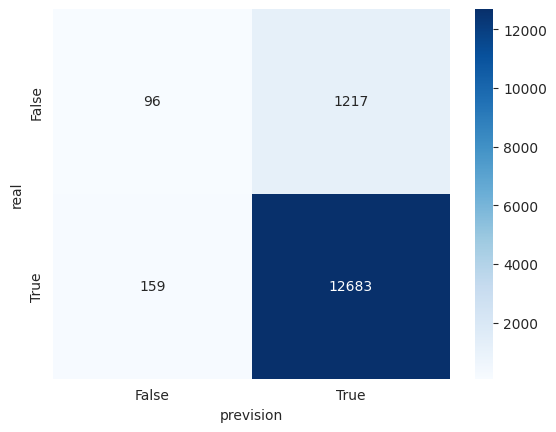

In [24]:
rfc_df = pd.DataFrame({'real': y_test, 'prevision': rfc_y_pred})

df = pd.DataFrame(rfc_df, columns=['real', 'prevision'])

cf_matrix = pd.crosstab(df['real'], df['prevision'], rownames=['real'], colnames=['prevision'])
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

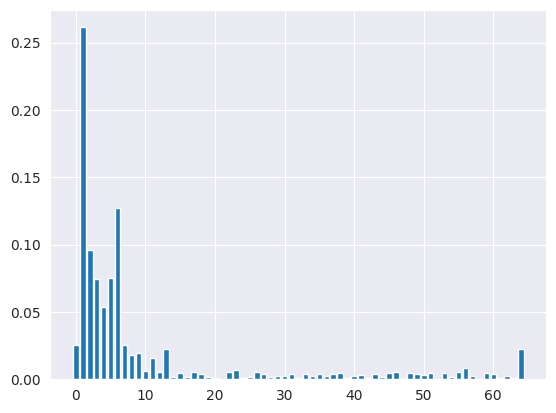

In [25]:
importance = rfc_model.feature_importances_

features = X.columns


best_feature = ""
best_score = 0

pair_features_scores = dict()

for i,v in enumerate(importance):
 #print(f'Feature: {features[i]}, Score: {v}')
 pair_features_scores[features[i]] = v
 if v > best_score:
     best_feature = features[i]
     best_score = v


plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [27]:
top_five = sorted(pair_features_scores.items(), key=lambda item: item[1], reverse=True)[:5]
top_five_features = dict(top_five)
print(top_five_features)

{'income': np.float64(0.2613462260231127), 'rooms': np.float64(0.12692293189998594), 'num_vehicles': np.float64(0.09591946640980778), 'gas_usage': np.float64(0.07516484942339327), 'age': np.float64(0.07473706176864145)}


## KNN


In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()  # You can adjust n_estimators
knn_model.fit(X_train, y_train)

knn_y_pred = knn_model.predict(X_test)

knn_metrics = evaluate_model(knn_model, X_test, y_test)

for metric, value in knn_metrics.items():
    print(f"{metric}: {value}")

accuracy: 0.8998940303779583
precision: 0.9114744651732335
recall: 0.9853605357420963
f1_score: 0.946978484565014
specifity: 0.06397562833206398
confusion_matrix: [[   84  1229]
 [  188 12654]]


<Axes: xlabel='prevision', ylabel='real'>

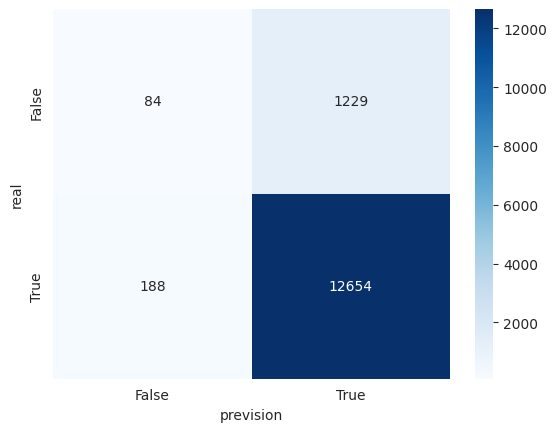

In [29]:
knn_df = pd.DataFrame({'real': y_test, 'prevision': knn_y_pred})

df = pd.DataFrame(knn_df, columns=['real', 'prevision'])

cf_matrix = pd.crosstab(df['real'], df['prevision'], rownames=['real'], colnames=['prevision'])
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

In [30]:
from sklearn.inspection import permutation_importance

results = permutation_importance(knn_model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

KeyboardInterrupt: 

# Predicting with smote


In [31]:
X_reduced, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_train, y_train)

In [35]:
rfc_model = RandomForestClassifier(n_estimators=100)  # You can adjust n_estimators
rfc_model.fit(X_sm, y_sm)

rfc_y_pred = rfc_model.predict(X_test)

rfc_metrics = evaluate_model(rfc_model, X_test, y_test)

for metric, value in rfc_metrics.items():
    print(f"{metric}: {value}")

accuracy: 0.8787707523843165
precision: 0.9196590223295111
recall: 0.9493069615324716
f1_score: 0.9342478350831481
specifity: 0.18888042650418888
confusion_matrix: [[  248  1065]
 [  651 12191]]


Doesnt work !!

<Axes: xlabel='prevision', ylabel='real'>

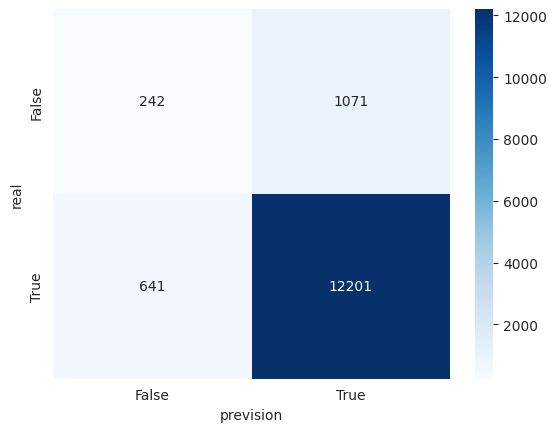

In [39]:
rfc_df = pd.DataFrame({'real': y_test, 'prevision': rfc_y_pred})

df = pd.DataFrame(rfc_df, columns=['real', 'prevision'])

cf_matrix = pd.crosstab(df['real'], df['prevision'], rownames=['real'], colnames=['prevision'])
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

## KNN


In [40]:
knn_model = KNeighborsClassifier()  # You can adjust n_estimators
knn_model.fit(X_sm, y_sm)

knn_y_pred = knn_model.predict(X_test)

knn_metrics = evaluate_model(knn_model, X_test, y_test)

for metric, value in knn_metrics.items():
    print(f"{metric}: {value}")

accuracy: 0.7905333804309431
precision: 0.9285032537960954
recall: 0.833281420339511
f1_score: 0.8783190380432552
specifity: 0.37242955064737243
confusion_matrix: [[  489   824]
 [ 2141 10701]]


# ANN

{'bodies': [<matplotlib.collections.PolyCollection at 0x7055671c8520>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x70556beedd80>,
 'cmins': <matplotlib.collections.LineCollection at 0x7055671c8af0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7055671c8eb0>}

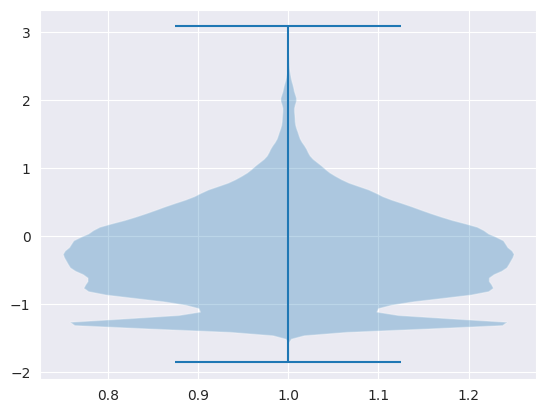

In [39]:
plt.violinplot(np.log1p(data["income"]))

In [40]:
data["income"].unique()

array([-0.35183473, -0.33137146, -0.36888746, ..., -0.29880074,
       -0.41987512, -0.269129  ])